# Classification of 'Sortedness' of Sequence of Cards using RelNN

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import sklearn.metrics
import pydealer

import relational_neural_networks

from hand2hand import Cards
import utils

In [3]:
%env "WANDB_NOTEBOOK_NAME" "relnn_hand_classifier.ipynb"

import wandb
wandb.login()

env: "WANDB_NOTEBOOK_NAME"="relnn_hand_classifier.ipynb"


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# utility functions

card_image_shape = (178, 122, 3)
hand_size = 7
class_names = ['not sorted', 'sorted']

def create_callbacks(monitor='loss', log_gradients=False, save_model=True, log_weights=True,
                     train_ds=None, val_ds=None, ):
    callbacks = [
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True),
#         tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
#         wandb.keras.WandbMetricsLogger(log_freq='epoch'),
#         wandb.keras.WandbModelCheckpoint(monitor=monitor, mode='auto', save_freq='epoch')
        wandb.keras.WandbCallback(
            monitor=monitor, log_weights=log_weights, log_gradients=log_gradients, save_model=save_model, save_graph=True,
            training_data=train_ds, validation_data=val_ds,
            labels=class_names, predictions=64, compute_flops=True)
        ]
    return callbacks

metrics = [
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(class_id=1, name='precision'),
        tf.keras.metrics.Recall(class_id=1, name='recall'),
        tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
        ]

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
opt = tf.keras.optimizers.Adam()

def get_preds(model, ds, print_classification_report=True):
    y_pred_proba = model.predict(ds.batch(128))
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.array([y for x,y in ds])
    if print_classification_report:
        print(sklearn.metrics.classification_report(y_true[:,1], y_pred))
    
    return y_true, y_pred_proba, y_pred

def log_to_wandb(y_test, pred_proba_test, pred_test):
    # log test-set metrics to W&B
    y_test = np.array(y_test[:,1])
    wandb.log({"pr": wandb.plot.pr_curve(y_test, pred_proba_test, class_names)})
    wandb.log({"roc": wandb.plot.roc_curve(y_test, pred_proba_test, labels=class_names)})
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(y_true=y_test, preds=pred_test, class_names=class_names)})

def wrap_run(model, ds):
    y_true, y_pred_proba, y_pred = get_preds(model, ds, print_classification_report=True)
    log_to_wandb(y_true, y_pred_proba, y_pred)
    wandb.finish()

fit_kwargs = {'epochs': 10}

2023-01-06 01:04:09.045472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 01:04:09.145899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 01:04:09.146763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 01:04:09.149027: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Buid Card Image Encoder via Training on Card Classification Trask

In [5]:
# create card classification dataset
card_rank_dict = pydealer.DEFAULT_RANKS['values']
card_suit_dict = pydealer.DEFAULT_RANKS['suits']

def card_classification_generator():
    deck = Cards()
    pydeck = pydealer.Deck()

    for card in pydeck:
        x = deck.image_of_pycard(card) / 255
        y = deck.index_of_card(card)
        yield x,y

card_classification_ds = tf.data.Dataset.from_generator(
     card_classification_generator,
     output_signature=(
         tf.TensorSpec(shape=card_image_shape, dtype=tf.float32),
         tf.TensorSpec(shape=(), dtype=tf.int32))
    )


In [6]:
img_input = layers.Input(shape=card_image_shape, name='card_image')

x = layers.Conv2D(32, (5, 5), activation='relu')(img_input)
x = layers.MaxPooling2D((4,4))(x)
x = layers.Conv2D(32, (5, 5), activation='relu')(x)
x = layers.MaxPooling2D((4,4))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)

card_encoder = Model(inputs=img_input, outputs=x, name='card_encoder')
card_classification = layers.Dense(52, name='card_classification')(card_encoder(img_input))

cnn_card_clf = Model(inputs=img_input, outputs=card_classification, name='card_cnn')

cnn_card_clf.summary()

cnn_card_clf.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     metrics=['accuracy'])

Model: "card_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
card_image (InputLayer)      [(None, 178, 122, 3)]     0         
_________________________________________________________________
card_encoder (Functional)    (None, 64)                138720    
_________________________________________________________________
card_classification (Dense)  (None, 52)                3380      
Total params: 142,100
Trainable params: 142,100
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = cnn_card_clf.fit(card_classification_ds.batch(52), epochs=50, verbose=0)

2023-01-06 01:04:11.701237: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-06 01:04:12.900812: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


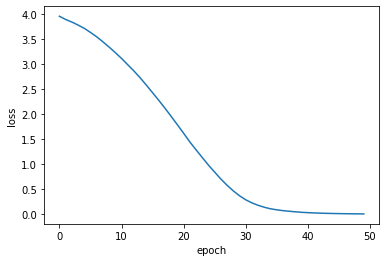

In [8]:
plt.plot(history.history['loss']);
plt.xlabel('epoch'); plt.ylabel('loss');

## Hand Classification Datasets: Tokenized Input and Image Input

In [9]:
# create 'toy' dataset where the cards in the input sequence are represented as an index in a vocab of length 52 

train_size = 10000

def create_tokenized_hand_clf_ds(seed=None, train_size=train_size):
    

    def tokenized_hand_clf_ds_generator():
        np.random.seed(seed) # optionally set seed for repeatability if desired

        deck = Cards()
        pydeck = pydealer.Deck()
        pydeck.shuffle()

        for i in np.arange(train_size):
            hand = pydeck.deal(hand_size)
            if len(hand) < hand_size:
                # ran out of cards, make a new deck
                pydeck = pydealer.Deck()
                pydeck.shuffle()
                hand = pydeck.deal(hand_size)
            if np.random.normal() < 0:
                deck.sort_pyhand(hand)

            x = deck.index_pyhand(hand)
            y = deck.is_sorted_pyhand(hand)
            yield x, y

    ds = tf.data.Dataset.from_generator(
         tokenized_hand_clf_ds_generator,
         output_signature=(
             tf.TensorSpec(shape=(hand_size, ), dtype=tf.int32),
             tf.TensorSpec(shape=(), dtype=tf.int32))
        )

    ds = ds.map(lambda x,y: (x, tf.one_hot(y,2)))
    
    return ds

In [10]:
# define dataset generator for sequence of card images

def create_img_hand_clf_ds(seed=None, train_size=train_size):


    def hand_classification_generator():
        np.random.seed(seed) # set seed for reproducibility of results

        deck = Cards()
        pydeck = pydealer.Deck()
        pydeck.shuffle()

        for i in np.arange(train_size):
            hand = pydeck.deal(hand_size)
            if len(hand) < hand_size:
                # ran out of cards, make a new deck
                pydeck = pydealer.Deck()
                pydeck.shuffle()
                hand = pydeck.deal(hand_size)
            if np.random.normal() < 0:
                deck.sort_pyhand(hand)

            x = np.array([deck.image_of_pycard(hand[j]) / 255 for j in range(hand_size)])
            y = deck.is_sorted_pyhand(hand)
            yield x,y

    ds = tf.data.Dataset.from_generator(
         hand_classification_generator,
         output_signature=(
             tf.TensorSpec(shape=(hand_size, *card_image_shape), dtype=tf.float32),
             tf.TensorSpec(shape=(), dtype=tf.int32))
        )

    ds = ds.map(lambda x,y: (x, tf.one_hot(y,2)))

    return ds

## Tokenized Input 

In [11]:
inputs = layers.Input(shape=(7, ))

x = layers.Embedding(52, 32, name='embedding')(inputs)

rel_encoders = [layers.Dense(16)]*4
rel_layer = relational_neural_networks.RelationalLayer(rel_encoders, name='relational_layer')
x = rel_layer(x)

x = relational_neural_networks.FlattenTriangular(name='flatten_triangular')(x)

x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

model = tf.keras.Model(inputs, outputs, name='relational_model')

model.summary()
model.compile(loss=loss, optimizer=opt, metrics=metrics)

Model: "relational_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 7, 32)             1664      
_________________________________________________________________
relational_layer (Relational (None, 7, 7, 4)           528       
_________________________________________________________________
flatten_triangular (FlattenT (None, 112)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 226       
Total params: 2,418
Trainable params: 2,418
Non-trainable params: 0
_________________________________________________________________


In [12]:
train_ds = create_tokenized_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='RelNN (Token Inputs)', save_code=True)

history = model.fit(train_ds.batch(256), callbacks=create_callbacks(save_model=False), **fit_kwargs)

wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin


2023-01-06 01:05:06.657369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 01:05:06.657767: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-06 01:05:06.657934: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-06 01:05:06.658453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 01:05:06.658849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 01:05:06.659203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/10
40/40 [==============================] - 4s 73ms/step - loss: 0.6493 - acc: 0.7870 - precision: 0.8604 - recall: 0.6815 - auc: 0.8863
Epoch 2/10
40/40 [==============================] - 3s 77ms/step - loss: 0.3064 - acc: 0.9052 - precision: 0.8695 - recall: 0.9546 - auc: 0.9574
Epoch 3/10
40/40 [==============================] - 3s 73ms/step - loss: 0.1477 - acc: 0.9474 - precision: 0.9292 - recall: 0.9683 - auc: 0.9856
Epoch 4/10
40/40 [==============================] - 3s 75ms/step - loss: 0.1255 - acc: 0.9563 - precision: 0.9453 - recall: 0.9692 - auc: 0.9886
Epoch 5/10
40/40 [==============================] - 3s 82ms/step - loss: 0.1087 - acc: 0.9650 - precision: 0.9567 - recall: 0.9739 - auc: 0.9916
Epoch 6/10
40/40 [==============================] - 3s 78ms/step - loss: 0.0976 - acc: 0.9666 - precision: 0.9568 - recall: 0.9783 - auc: 0.9929
Epoch 7/10
40/40 [==============================] - 3s 72ms/step - loss: 0.0890 - acc: 0.9725 - precision: 0.9622 - recall: 0.9836

In [13]:
test_ds = create_tokenized_hand_clf_ds(seed=42)
model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(model, test_ds)

40/40 [==============================] - 4s 77ms/step - loss: 0.0608 - acc: 0.9827 - precision: 0.9752 - recall: 0.9906 - auc: 0.9963
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      4992
         1.0       0.98      0.99      0.99      5008

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



acc,▁▅▇▇▇▇████
auc,▁▅▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▂▂▁▁▁▁▁
precision,▁▂▅▆▇▇▇███
recall,▁▇▇▇██████
GFLOPs,2e-05
acc,0.9836
auc,0.99709
best_epoch,9
best_loss,0.05745


## Full Card Clf as Encoder

In [14]:
inputs = layers.Input(shape=(hand_size, *card_image_shape))
x = layers.TimeDistributed(cnn_card_clf, name='card_clf_encoder', trainable=False)(inputs)

rel_encoders = [layers.Dense(16)]*4
rel_layer = relational_neural_networks.RelationalLayer(rel_encoders, name='relational_layer')
x = rel_layer(x)

x = relational_neural_networks.FlattenTriangular(name='flatten_triangular')(x)

x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

model = tf.keras.Model(inputs, outputs, name='relational_model')

model.summary()
model.compile(loss=loss, optimizer=opt, metrics=metrics)

Model: "relational_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 178, 122, 3)]  0         
_________________________________________________________________
card_clf_encoder (TimeDistri (None, 7, 52)             142100    
_________________________________________________________________
relational_layer (Relational (None, 7, 7, 4)           848       
_________________________________________________________________
flatten_triangular (FlattenT (None, 112)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 226       
Total params: 143,174
Trainable params: 1,074
Non-trainable params: 142,100
_________________________________________________________________


In [15]:
train_ds = create_img_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='RelNN (Image Inputs, Clf Encoder)', save_code=True)

history = model.fit(train_ds.batch(256), callbacks=create_callbacks(save_model=False), **fit_kwargs)

2023-01-06 01:07:09.061357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 01:07:09.061708: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-06 01:07:09.061884: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-06 01:07:09.062442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 01:07:09.062863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 01:07:09.063292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/10


2023-01-06 01:07:11.855866: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


40/40 [==============================] - 22s 504ms/step - loss: 400.6165 - acc: 0.7785 - precision: 0.7671 - recall: 0.7989 - auc: 0.7474
Epoch 2/10
40/40 [==============================] - 21s 515ms/step - loss: 18.4914 - acc: 0.7229 - precision: 0.7292 - recall: 0.7056 - auc: 0.7293
Epoch 3/10
40/40 [==============================] - 21s 532ms/step - loss: 8.2831 - acc: 0.7920 - precision: 0.7910 - recall: 0.7939 - auc: 0.8037
Epoch 4/10
40/40 [==============================] - 22s 539ms/step - loss: 5.9709 - acc: 0.8057 - precision: 0.8091 - recall: 0.7935 - auc: 0.8190
Epoch 5/10
40/40 [==============================] - 21s 534ms/step - loss: 4.6725 - acc: 0.8156 - precision: 0.8143 - recall: 0.8211 - auc: 0.8337
Epoch 6/10
40/40 [==============================] - 20s 508ms/step - loss: 3.7352 - acc: 0.8204 - precision: 0.8254 - recall: 0.8131 - auc: 0.8411
Epoch 7/10
40/40 [==============================] - 22s 532ms/step - loss: 2.9597 - acc: 0.8367 - precision: 0.8367 - recall: 

In [16]:
test_ds = create_img_hand_clf_ds(seed=42)
model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(model, test_ds)

40/40 [==============================] - 22s 522ms/step - loss: 1.7108 - acc: 0.8347 - precision: 0.8547 - recall: 0.8071 - auc: 0.8747
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83      4991
         1.0       0.85      0.80      0.82      5009

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



acc,▄▁▅▆▇▇████
auc,▂▁▅▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
precision,▃▁▅▆▆▇████
recall,▆▁▆▆▇▇█▇▇█
GFLOPs,0.52522
acc,0.839
auc,0.8713
best_epoch,9
best_loss,1.88106


## Classifier's Intermediate Encoder as Card Encoder

In [17]:
inputs = layers.Input(shape=(hand_size, *card_image_shape))
x = layers.TimeDistributed(card_encoder, name='card_encoder', trainable=False)(inputs)

rel_encoders = [layers.Dense(16)]*4
rel_layer = relational_neural_networks.RelationalLayer(rel_encoders, name='relational_layer')
x = rel_layer(x)

x = relational_neural_networks.FlattenTriangular(name='flatten_triangular')(x)

x = layers.Dense(2, activation='softmax', name='output')(x)

outputs = x

model = tf.keras.Model(inputs, outputs, name='relational_model')

model.summary()
model.compile(loss=loss, optimizer=opt, metrics=metrics)

Model: "relational_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 7, 178, 122, 3)]  0         
_________________________________________________________________
card_encoder (TimeDistribute (None, 7, 64)             138720    
_________________________________________________________________
relational_layer (Relational (None, 7, 7, 4)           1040      
_________________________________________________________________
flatten_triangular (FlattenT (None, 112)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 226       
Total params: 139,986
Trainable params: 1,266
Non-trainable params: 138,720
_________________________________________________________________


In [18]:
train_ds = create_img_hand_clf_ds(seed=None)

run = wandb.init(project='Abstracter Hand Classification', group='RelNN (Image Inputs, Intermediate Encoder)', save_code=True)

history = model.fit(train_ds.batch(256), callbacks=create_callbacks(save_model=False), **fit_kwargs)

2023-01-06 01:15:32.336129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 01:15:32.336657: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-01-06 01:15:32.336837: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-06 01:15:32.338590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 01:15:32.339156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 01:15:32.339601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/10
40/40 [==============================] - 23s 530ms/step - loss: 318.5425 - acc: 0.7043 - precision: 0.7104 - recall: 0.6872 - auc: 0.7157
Epoch 2/10
40/40 [==============================] - 21s 518ms/step - loss: 31.1389 - acc: 0.7552 - precision: 0.7529 - recall: 0.7508 - auc: 0.7592
Epoch 3/10
40/40 [==============================] - 21s 519ms/step - loss: 14.1360 - acc: 0.8176 - precision: 0.8199 - recall: 0.8219 - auc: 0.8248
Epoch 4/10
40/40 [==============================] - 21s 525ms/step - loss: 9.1320 - acc: 0.8506 - precision: 0.8538 - recall: 0.8435 - auc: 0.8570
Epoch 5/10
40/40 [==============================] - 21s 519ms/step - loss: 7.3514 - acc: 0.8676 - precision: 0.8697 - recall: 0.8673 - auc: 0.8755
Epoch 6/10
40/40 [==============================] - 22s 544ms/step - loss: 6.2090 - acc: 0.8751 - precision: 0.8790 - recall: 0.8778 - auc: 0.8832
Epoch 7/10
40/40 [==============================] - 21s 528ms/step - loss: 4.8654 - acc: 0.8903 - precision: 0.891

In [19]:
test_ds = create_img_hand_clf_ds(seed=42)
model.evaluate(test_ds.batch(256), return_dict=True);
wrap_run(model, test_ds)

40/40 [==============================] - 22s 528ms/step - loss: 3.2832 - acc: 0.8964 - precision: 0.9172 - recall: 0.8718 - auc: 0.9072
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      4990
         1.0       0.92      0.86      0.89      5010

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



acc,▁▃▅▆▇▇████
auc,▁▃▅▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
precision,▁▃▅▆▇▇████
recall,▁▃▅▆▇▇██▇█
GFLOPs,0.5252
acc,0.9007
auc,0.91015
best_epoch,9
best_loss,3.44289
